# Aula 05 - Avaliação de Sistemas de Recomendação - Exercícios

In [1]:
import pandas as pd
import numpy as np

### Importar base de dados

In [2]:
import wget
!python3 -m wget https://github.com/mmanzato/MBABigData/raw/master/ml-20m-compact.tar.gz
!tar -xvzf ml-20m-compact.tar.gz

100% [....................................................] 65019041 / 65019041
Saved under ml-20m-compact.tar.gz
dataset/
dataset/tags_sample.csv
dataset/._.DS_Store
dataset/.DS_Store
dataset/movies_sample.csv
dataset/._genome-tags.csv
dataset/genome-tags.csv
dataset/._ml-youtube.csv
dataset/ml-youtube.csv
dataset/._genome-scores.csv
dataset/genome-scores.csv
dataset/ratings_sample.csv


In [3]:
movies = pd.read_csv('./dataset/movies_sample.csv')
ratings = pd.read_csv('./dataset/ratings_sample.csv')
df = ratings[['userId', 'movieId', 'rating']]
df = df.merge(movies[['movieId', 'title']])
df

,userId,movieId,rating,title
0,11,7481,5.0,Enemy Mine (1985)
1,11,1046,4.5,Beautiful Thing (1996)
2,11,616,4.0,"Aristocats, The (1970)"
3,11,3535,2.0,American Psycho (2000)
4,11,5669,5.0,Bowling for Columbine (2002)
...,...,...,...,...
190616,138493,288,5.0,Natural Born Killers (1994)
190617,138493,1748,5.0,Dark City (1998)
190618,138493,616,4.0,"Aristocats, The (1970)"
190619,138493,1597,4.5,Conspiracy Theory (1997)


In [4]:
movies_genres = movies.drop('genres', axis=1).join(movies.genres.str.split('|', expand=True)
             .stack().reset_index(drop=True, level=1).rename('genre'))
movies_genres.head()

,movieId,title,genre
0,30,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,Crime
0,30,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,Drama
1,31,Dangerous Minds (1995),Drama
2,37,Across the Sea of Time (1995),Documentary
2,37,Across the Sea of Time (1995),IMAX


In [5]:
movies_tags = pd.read_csv('./dataset/tags_sample.csv')
movies_tags.head()

,userId,movieId,tag,timestamp_y
0,279,916,Gregory Peck,1329962459
1,279,916,need to own,1329962471
2,279,916,romantic comedy,1329962476
3,279,916,Rome,1329962490
4,279,916,royalty,1329962474


In [6]:
map_users = {user: idx for idx, user in enumerate(df.userId.unique())}
map_items = {item: idx for idx, item in enumerate(df.movieId.unique())}

df['userId'] = df['userId'].map(map_users)
df['movieId'] = df['movieId'].map(map_items)

movies_tags['userId'] = movies_tags['userId'].map(map_users)
movies_tags['movieId'] = movies_tags['movieId'].map(map_items)
movies_tags.dropna(inplace=True)
movies_tags['movieId'] = movies_tags.movieId.astype(int)
movies_tags['userId'] = movies_tags.userId.astype(int)

movies_genres['movieId'] = movies_genres['movieId'].map(map_items)
movies_genres.dropna(inplace=True)
movies_genres['movieId'] = movies_genres.movieId.astype(int)

map_title = {}
for _, row in df.iterrows():
    map_title[row.movieId] = row.title


In [7]:
movies_genres[['movieId', 'genre']].to_csv('items_genres.dat', index=False, sep='\t', header=False)
movies_tags[['movieId', 'tag']].to_csv('items_tags.dat', index=False, sep='\t', header=False)

### Divisão da base em treino e teste

In [8]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=.2, random_state=2)
train.to_csv('train.dat', index=False, header=False, sep='\t')
test.to_csv('test.dat', index=False, header=False, sep='\t')

### Exemplos de utilização do CaseRecommender

In [9]:
from caserec.recommenders.rating_prediction.item_attribute_knn import ItemAttributeKNN

ItemAttributeKNN('train.dat', 'test.dat', metadata_file='items_genres.dat', k_neighbors=10, as_similar_first=True).compute()
ItemAttributeKNN('train.dat', 'test.dat', metadata_file='items_tags.dat', k_neighbors=10, as_similar_first=True).compute()

[Case Recommender: Rating Prediction > Item Attribute KNN Algorithm]

train data:: 11090 users and 405 items (152496 interactions) | sparsity:: 96.60%
test data:: 10571 users and 331 items (38125 interactions) | sparsity:: 98.91%

training_time:: 3.365583 sec
>> metadata:: 417 items and 20 metadata (890 interactions) | sparsity:: 89.33%
prediction_time:: 0.356102 sec
Eval:: MAE: 0.73347 RMSE: 0.964352 
[Case Recommender: Rating Prediction > Item Attribute KNN Algorithm]

train data:: 11090 users and 405 items (152496 interactions) | sparsity:: 96.60%
test data:: 10571 users and 331 items (38125 interactions) | sparsity:: 98.91%

training_time:: 3.476048 sec
>> metadata:: 231 items and 1979 metadata (6274 interactions) | sparsity:: 98.63%
prediction_time:: 0.444583 sec
Eval:: MAE: 0.765116 RMSE: 1.006911 


***Exercício 01:*** Verifique o efeito no RSME ao aumentar o número de vizinhos do algoritmo ItemAttributeKNN com usando gêneros. Explique.

In [10]:
! mkdir -p results
! mkdir -p metrics

In [11]:
# To ensure our analysis is consistent, we will be saving the inputs and outputs of every experiment
#  in two dictionaries, one for the inputs and one for the outputs.
variables = dict()
awnsers = dict()

In [12]:
# Modules needed for this exercise
import re
import io
from contextlib import redirect_stdout
import matplotlib.pyplot as plt

In [13]:
# Some support functions

# Shorthand to make it easier to test different k values
def create_knn_model(k : int, save_it=True):
    return ItemAttributeKNN(
        'train.dat', 
        'test.dat', 
        f'results/item_attrib_knn_k_{k}.dat' if save_it else None,
        metadata_file='items_genres.dat', 
        k_neighbors=k, 
        as_similar_first=True
    )

# Function to capture output and extract RMSE
def compute(model, model_name = None):
    f = io.StringIO()
    
    with redirect_stdout(f):
        model.compute()
        
    produced = f.getvalue()
    
    if model_name is not None:
        with open(f'metrics/{model_name}.txt', 'w') as f:
            f.write(produced)
        
    return produced


# Function to extract RMSE from the output using regex
def extract_rmse(report):
    # Use regex to extract RMSE from the output
    rmse_match = re.search(r'RMSE:\s+([\d.]+)', report)
    return float(rmse_match.group(1)) if rmse_match else None


def compute_rmse(k_values, save_it=True):
    for k in k_values:
        model_name = f'item_attrib_knn_k_{k}'
        
        model = create_knn_model(k, save_it)
        report = compute(model, model_name)
        rmse = extract_rmse(report)
        
        yield rmse
        
def plot_rmse(k_values : list[int], rmse_values : list[float]):
    plt.plot(k_values, rmse_values)
    plt.xlabel('k')
    plt.ylabel('RMSE')
    plt.title('RMSE for different k values')
    plt.show()

In [14]:
# BEWARE! This cell may take a few minutes to run.

# Exercise 01 - Experiment 01
# Testing different k values
variables['q01-t01'] = list(range(10, 100 + 1, 20))

# Perform the experiment
awnsers['q01-t01'] = list(compute_rmse(variables['q01-t01']))

# Results
awnsers['q01-t01']

[0.964352, 0.963254, 0.965269, 0.957595, 0.948382]

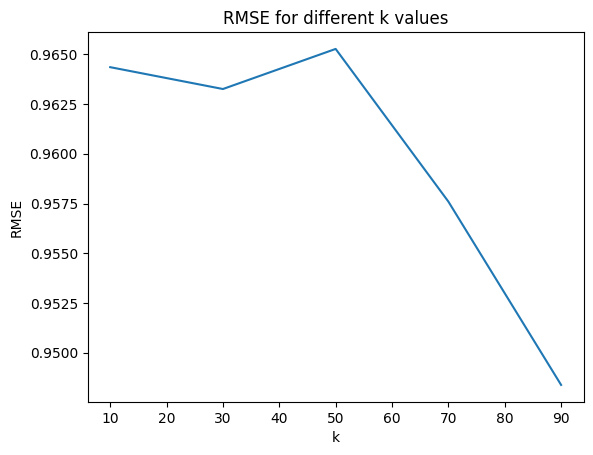

In [15]:
plot_rmse(variables['q01-t01'], awnsers['q01-t01'])

Testando para valores maiores, obtemos:

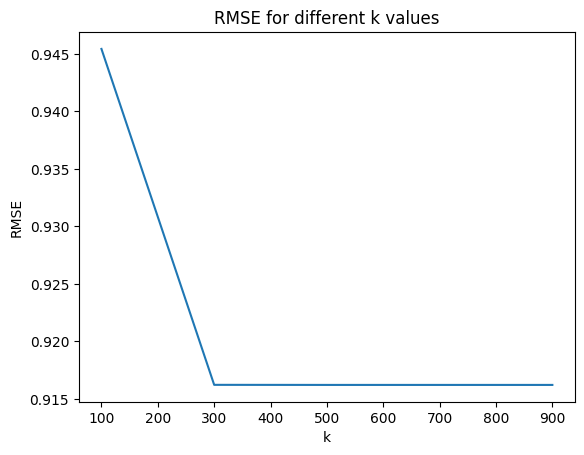

In [17]:
# BEWARE! This cell may take a few minutes to run.

# Exercise 1 - Experiment 2
variables['q01-t02'] = range(100, 1100, 200)
awnsers['q01-t02'] = list(compute_rmse(variables['q01-t02'], save_it=False))
plot_rmse(variables['q01-t02'], awnsers['q01-t02'])

Nos testes realizados, observamos que o erro médio tende a diminuir conforme o
 hiperparâmetro $(k)$ aumenta, até atingir um platô e se estabilizar em aproximadamente
 $k \approx 300$.

É de se esperar que algoritmos baseados em KNN gerem predições mais genéricas conforme o valor de $k$ aumenta.
 Essas predições genéricas se comportam como uma "predição média" do dataset,
 o que implica em um RMSE pequeno, mas a um custo de menor especialização nas recomendações.
 Ou seja, apesar do erro pequeno, essas recomendações podem não ser muito úteis para cada usuário.
 Nesses casos, a precisão do modelo é priorizada, enquanto a diversidade, a novidade e
 a serendipidade são menosprezadas.

Esse fenômeno é uma consequência da natureza do método utilizado.
 Algoritmos baseados em KNN, por definição, usam os $k$ vizinhos mais similares para fazer suas predições.
 Assim, para valores pequenos de $k$, a similaridade dos vizinhos mais próximos produz 
 uma recomendação mais especializada. Para valores grandes de $k$, a diversidade do subconjunto dos 
 vizinhos selecionados sobressai à similaridade. 
 Desse modo, as características médias do dataset se tornam proeminentes,
 o que resulta em uma recomendação mais genérica.
 Portanto, é fundamental encontrar um equilíbrio adequado para o valor de $k$,
 garantindo que as recomendações permaneçam úteis para cada usuário sem sacrificar a precisão.


***Exercício 02:*** Verifique o efeito na métrica MAP@1 ao aumentar o número de fatores do algoritmo BPRMF. Explique.

In [18]:
# Making sure the results folder exists
! mkdir -p results
! mkdir -p metrics

In [19]:
# Needed modules
from caserec.recommenders.item_recommendation.bprmf import BprMF

In [20]:
# Utility functions
def create_bprmf_model(factors : int):
    return BprMF(
        train_file='train.dat', 
        test_file='test.dat', 
        output_file=f'results/bprmf_factors_{factors}.dat',
        factors=factors
    )

# Function to extract the metadata produced by the model
def extract_model_metrics(text):
    # Find all "Eval::" lines and their corresponding metrics
    eval_lines = re.findall(r"Eval::(.+)", text)
    
    all_metrics = []
    for line in eval_lines:
        # Using a regex pattern to extract key-value pairs from each Eval line
        metrics = re.findall(r'(\S+):\s*([\d.]+)', line)
        # Convert to dictionary with the appropriate float conversion for values
        metrics_dict = {key: float(value) for key, value in metrics}
        all_metrics.append(metrics_dict)
    
    return all_metrics

def get_metrics(text, important_metrics = None, multiple_lines=False):
    metrics = extract_model_metrics(text)
    
    # By default, if multiple "eval" lines are present, we only consider the last one
    if not multiple_lines: metrics = metrics[-1]
    
    if important_metrics is None:
        return metrics
    else:
        return {metric: metrics[metric] for metric in important_metrics}

def compute_bprmf(factors_values):
    for factors in factors_values:
        model_name = f'bprmf_factors_{factors}'
        
        model = create_bprmf_model(factors)
        report = compute(model, model_name)
        metrics = get_metrics(report, ['MAP@1'])
        
        yield metrics
        
def plot_bprmf_map(factors_values, map_values):
    plt.plot(factors_values, map_values)
    plt.xlabel('Factors')
    plt.ylabel('MAP@1')
    plt.title('MAP@1 for different number of factors')
    plt.show()
        

In [ ]:
# BEWARE! This cell may take a long time to run.
# Expected time: about 30min to 1h

# Testing for multiple factors values
variables['ex-02'] = [1, 3, 5, 10, 20]

# Getting the results
awnsers['ex-02'] = list(compute_bprmf(variables['ex-02']))

# Showing the results
awnsers['ex-02']

In [ ]:
# Extracting the MAP@1 values from the results dictionary
bprmf_map_list = [metrics['MAP@1'] for metrics in awnsers['ex-02']]

# Plotting the results
plot_bprmf_map(variables['ex-02'], bprmf_map_list)

O BprMF é um modelo baseado em fatoração de matrizes. Quanto maior o número de fatores, maior a complexidade do modelo. Desse modo, excluindo a possibilidade de overfiting, aumentar o número de fatores aumenta a capacidade do modelo de capturar as características latentes nas interações entre usuários e itens. No entanto, conforme o número de fatores aumenta, o modelo pode passar a dar overfitting e sofrer da maldição da dimensionalidade. Ou seja, eventualmente, o aumento do número de fatores resulta em uma piora da performance. Porém, até esse ponto, observamos um aumento da medida "MAP@1".

***Exercício 03:*** Implemente a métrica Average Precision para um único usuário. Utilize as recomendações geradas pelo algoritmo BPRMF (consulte notebook Aula04_Exemplo como base).

In [25]:
import random

In [26]:
# Reading the predictions
factors = 3
BprMF_pred = pd.read_csv(f'results/bprmf_factors_{factors}.dat', sep='\t', names=['userId', 'movieId', 'prediction'])
BprMF_pred.head()

,userId,movieId,prediction
0,0,36,8.456659
1,0,64,8.438413
2,0,171,8.040862
3,0,55,7.871878
4,0,19,7.857437


In [27]:
# Support functions

# NOTE: not very optimal... too bad.
def average_precision(predictions, ground_truth, relevance_threshold=3):
    # Merge the dataframes
    merged_df = pd.merge(predictions, ground_truth, on=['userId', 'movieId'], how='left')
    
    # Assume 0 for missing ratings
    merged_df['rating'] = merged_df['rating'].fillna(0)
    
    # Binarize the ratings
    merged_df['relevant'] = merged_df['rating'] >= relevance_threshold
    
    # Sort the values by userId and prediction in descending order
    merged_df = merged_df.sort_values(['userId', 'prediction'], ascending=[True, False])
    
    # Dictionary to store the AP for each user
    aps = {}
    
    # Iterate over each user
    for user_id, group in merged_df.groupby('userId'):
        # How many relevant items the user has rated?
        num_relevant = group['relevant'].sum() 
        
        # If no relevant items, AP is 0
        if num_relevant == 0:
            aps[user_id] = 0
            continue
        
        # Number of hits
        cumulative_hits = 0
        precision_sum = 0.0
        
        # Go through each ranked item and calculate precision
        for rank, row in enumerate(group.itertuples(), 1):
            if row.relevant:  # If this item is relevant
                cumulative_hits += 1
                precision_at_k = cumulative_hits / rank
                precision_sum += precision_at_k
                
        # Average Precision for this user
        ap = precision_sum / num_relevant
        aps[user_id] = ap
    
    return aps

In [28]:
# Selecting a random user
sample_size = 1
list_of_users = BprMF_pred.userId.unique().tolist()
random.seed(42) # For reproducibility
random_users = random.sample(list_of_users, sample_size)

# Filtering the predictions for the selected user
BprMF_pred_user = BprMF_pred[BprMF_pred.userId.isin(random_users)]

# Calculating the mean precision for the selected user
awnsers['ex-03'] = average_precision(
    predictions=BprMF_pred_user,
    ground_truth=df,
    relevance_threshold=3 # Considering ratings >= 3 as relevant
)

# Showing the results
awnsers['ex-03']

{10476: 0.8041666666666667}

***Exercício 04:*** Um importante aspecto que pode ser avaliado em Sistemas de Recomendação é a diversidade da lista de recomendações. A métrica Intra-List Similarity (ILS) aplica uma função de similaridade (e.g. Cosseno, Jaccard, Pearson, etc.) entre todos os pares de itens da lista de recomendação, usando seus metadados como gêneros, tags, etc. Mais detalhes sobre essa métrica podem ser encontrados em: https://grouplens.org/site-content/uploads/Improving-WWW-20051.pdf

***a)*** Implemente uma função que calcula a ILS de uma lista de recomendação para um único usuário. Utilize os gêneros de filmes.

In [29]:
def get_genres(movieId):
    return movies_genres[movies_genres.movieId == movieId].genre.values


def similarity_score(movieId1, movieId2):
    # Get the genres
    genre_set_1 = set(get_genres(movieId1))
    genre_set_2 = set(get_genres(movieId2))

    # Calculate the intersection and union of the genre sets
    intersection_size = len(genre_set_1 & genre_set_2)
    union_size = len(genre_set_1 | genre_set_2)
    
    # Calculate Jaccard similarity
    return intersection_size / union_size if union_size > 0 else 0


# get similarity matrix for all items
def get_similarity_matrix():
    n_items = df.movieId.max() + 1
    similarity_matrix = np.zeros((n_items, n_items))
    for i in range(n_items):
        for j in range(n_items):
            similarity_matrix[i][j] = similarity_score(i, j)
        
    return similarity_matrix


def recomend_movies(user_id, n, predictions, ratings):
    # Remove already rated movies
    predictions = predictions[~predictions.movieId.isin(ratings[ratings.userId == user_id].movieId)]
    
    # Get the top n movies
    top_n = predictions[predictions.userId == user_id].nlargest(n, 'prediction')
    
    # Remove the userId column
    top_n = top_n.drop('userId', axis=1)
    
    return top_n.movieId.tolist()


# TODO: optimize this
def calculate_ILS(recommendations, similarity_matrix):
    # Shorthand
    n = len(recommendations)
    
    # Trivial case: we need at least two movies
    if n < 2: return 0.0

    # Initialize a list to store similarity scores between all pairs
    similarity_scores = []
    
    # Loop over all pairs of movies in the recommendation list
    for i in range(n):
        for j in range(i + 1, n):
            movie_i = recommendations[i]
            movie_j = recommendations[j]
            
            # Get the similarity from the similarity matrix
            sim_ij = similarity_matrix[movie_i, movie_j]
            similarity_scores.append(sim_ij)
    
    # Calculate the average similarity
    ils = np.mean(similarity_scores)
    
    return ils

In [30]:
# Pre-compute the similarity matrix
sim_matrix = get_similarity_matrix()

In [31]:
# Select a random user
list_of_users = BprMF_pred.userId.unique().tolist()
random.seed(42) # For reproducibility
random_users = random.sample(list_of_users, 1)

# Getting recomendations for the selected user
number_of_recomendations = 10
recomendations = recomend_movies(
    user_id=random_users[0],
    n=number_of_recomendations,
    predictions=BprMF_pred,
    ratings=df
)

# Calculating the ILS for the selected user
awnsers['ex-04'] = calculate_ILS(recomendations, sim_matrix)

# Showing the results
awnsers['ex-04']

0.2

***b)*** Utilize a função que implementou no item (a) para calcular a ILS de todos os usuários da base de dados. Utilize as recomendações geradas pelo algoritmo BPR MF do CaseRecommender.

In [32]:
def ILS(predictions, ratings, sim_matrix, n):
    user_ids = predictions.userId.unique()
    
    # Compute ils for each user
    for user_id in user_ids:
        recomendations = recomend_movies(user_id, n, predictions, ratings)
        yield user_id, calculate_ILS(recomendations, sim_matrix)

In [ ]:
# Preparing the execution
ILS_values = ILS(
    predictions=BprMF_pred,
    ratings=df,
    sim_matrix=sim_matrix,
    n=10
)

# Computing the results
awnsers['ex-05'] = list(ILS_values)

awnsers['ex-05'] 

***c)*** Aplique a função que implementou no item (b) para calcular a ILS das recomendações geradas pelos algoritmos ItemKNN e ItemAttributeKNN. Compare os resultados de todos os algoritmos, verificando inclusive o que acontece com a acurácia (precisão, MAP ou NDCG) quando a diversidade aumenta ou diminui.

In [129]:
# Needed modules
import os

In [148]:
# Support functions

# Read all the model data (predictions and metrics)
def read_models():
    # read all files in results folder
    filenames_dat = os.listdir('results')
    # filenames_no_ext = [os.path.splitext(filename)[0] for filename in filenames_dat]
    
    read_df = lambda filename: pd.read_csv(f'results/{filename}', sep='\t', names=['userId', 'movieId', 'prediction'])
    
    models_pred = {filename: read_df(filename) for filename in filenames_dat}
    
    # function to substitute the .dat extension for .txt
    replace_dat = lambda x: x.replace('.dat', '.txt')
    read_metric = lambda filename: open(f'metrics/{filename}').read()
    
    filenames_txt = map(replace_dat, filenames_dat)
    models_metrics = {filename: read_metric(filename) for filename in filenames_txt}
    
    filenames_no_ext = [os.path.splitext(filename)[0] for filename in filenames_dat]
    
    return {
        name: {'predictions': data, 'metrics': metric} 
        for name, data, metric in 
        zip(filenames_no_ext, models_pred.values(), models_metrics.values())
    }
    

In [185]:
# Reading everything we done so far
models = read_models()

In [ ]:
number_of_recomendations = 10

all_ils = {
    name: list(ILS(data['predictions'], df, sim_matrix, number_of_recomendations))
    for name, data in models.items()
}

In [167]:
selected_models_name = [f'item_attrib_knn_k_{k}' for k in range(10, 30 + 1, 20)]
selected_models = [models[name] for name in selected_models_name]
metrics_evolution = [get_metrics(m['metrics'], ['RMSE']) for m in selected_models]
ils_evolution = [all_ils[name] for name in selected_models_name]

In [172]:
def plot_evolution(rmse_list, ils_list):
    plt.figure(figsize=(8, 6))
    
    # Plot RMSE vs ILS
    plt.plot(rmse_list, ils_list, marker='o', linestyle='-', color='b', label='RMSE vs ILS')
    
    # Add labels and title
    plt.xlabel('RMSE')
    plt.ylabel('ILS (Intra-List Similarity)')
    plt.title('RMSE Evolution vs ILS Evolution')
    
    # Add a grid and legend
    plt.grid(True)
    plt.legend()
    
    # Show the plot
    plt.show()

In [ ]:
rmse_list = [m['RMSE'] for m in metrics_evolution]
ils_list = [np.mean([ils for _, ils in ils]) for ils in ils_evolution]

plot_evolution(rmse_list, ils_list)